# Carica i dati

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.3.2")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.plots") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.plots") \
    .getOrCreate()

plots_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
plots_df.show()

+---------+--------------------+--------------------+
|      _id|       plot_synopsis|               title|
+---------+--------------------+--------------------+
|tt0000091|The film opens wi...| Le manoir du diable|
|tt0000225|A widower merchan...| La belle et la bête|
|tt0000230|A prologue in fro...|          Cendrillon|
|tt0000417|At a meeting of t...|Le voyage dans la...|
|tt0000488|Joe is an impover...|The Land Beyond t...|
|tt0000634|Mark Antony – one...|Antony and Cleopatra|
|tt0000709|The play opens wi...|       Julius Caesar|
|tt0000966|The play consists...|A Midsummer Night...|
|tt0001223|The film starts w...|        Frankenstein|
|tt0001227|Dr. Richard Kimbl...|        The Fugitive|
|tt0001724|Two men who are f...|The Last Drop of ...|
|tt0001915|=== Book the Firs...|A Tale of Two Cities|
|tt0002130|The exhumation of...|           L'Inferno|
|tt0003419|Being praised as ...|Der Student von Prag|
|tt0003489|In Pompeii 79AD, ...|Gli ultimi giorni...|
|tt0004022|The play opens wi

In [2]:
spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.tags") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.tags") \
    .getOrCreate()
tags = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

tags_df = tags.join(plots_df, tags._id == plots_df._id, how='inner').select(tags._id, 'title', 'plot_synopsis', 'tags')
tags_df.show()

+---------+--------------------+--------------------+--------------------+
|      _id|               title|       plot_synopsis|                tags|
+---------+--------------------+--------------------+--------------------+
|tt0021156|             Morocco|The film is set i...|   revenge, romantic|
|tt0032553|  The Great Dictator|During a battle i...|comedy, anti war,...|
|tt0034269|               Texas|Two Confederate v...|    romantic, murder|
|tt0038958|   So Dark the Night|So Dark the Night...|              murder|
|tt0039305|      Dead Reckoning|Leaving a church,...|plot twist, murde...|
|tt0039431|           Good News|The film is set i...|       psychological|
|tt0039896|They Won't Believ...|After the prosecu...|   murder, flashback|
|tt0042475| A Fractured Leghorn|The cat is fishin...|         psychedelic|
|tt0042899|      Rocky Mountain|A car pulls up to...|            violence|
|tt0043973|           Roadblock|Insurance investi...|              murder|
|tt0052811|The Flesh and 

# Divisione training-test

In [3]:
from pyspark.sql.types import *

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.metadata") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.metadata") \
    .getOrCreate()
traintest_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
joined_tt_df = tags_df.join(traintest_df, tags_df._id == traintest_df._id, how='inner')\
    .select(tags._id, 'title', 'plot_synopsis', 'tags', 'split')
joined_tt_df.show()

+---------+--------------------+--------------------+--------------------+-----+
|      _id|               title|       plot_synopsis|                tags|split|
+---------+--------------------+--------------------+--------------------+-----+
|tt0021156|             Morocco|The film is set i...|   revenge, romantic|train|
|tt0032553|  The Great Dictator|During a battle i...|comedy, anti war,...|train|
|tt0034269|               Texas|Two Confederate v...|    romantic, murder|  val|
|tt0038958|   So Dark the Night|So Dark the Night...|              murder|train|
|tt0039305|      Dead Reckoning|Leaving a church,...|plot twist, murde...| test|
|tt0039431|           Good News|The film is set i...|       psychological|train|
|tt0039896|They Won't Believ...|After the prosecu...|   murder, flashback|train|
|tt0042475| A Fractured Leghorn|The cat is fishin...|         psychedelic| test|
|tt0042899|      Rocky Mountain|A car pulls up to...|            violence|train|
|tt0043973|           Roadbl

# Analisi tag/generi

In [4]:
genres = joined_tt_df.rdd\
    .map(lambda x: (x.tags))\
    .flatMap(lambda x: [genre for genre in x.split(', ')])

ordered_genres = genres\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .collect()
ordered_genres.sort(key=lambda x: x[1], reverse=True)
ordered_genres[:10]

[('murder', 5782),
 ('violence', 4426),
 ('flashback', 2937),
 ('romantic', 2906),
 ('cult', 2647),
 ('revenge', 2468),
 ('psychedelic', 1897),
 ('comedy', 1859),
 ('suspenseful', 1086),
 ('good versus evil', 875)]

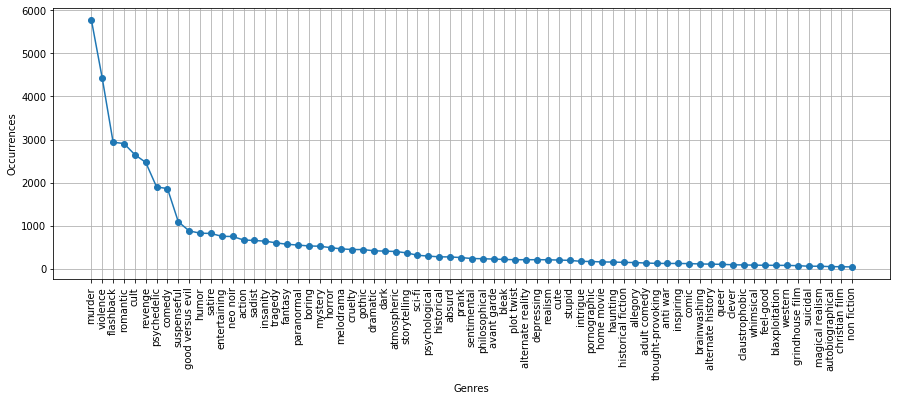

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))
plt.grid()
plt.plot([x[0] for x in ordered_genres], [x[1] for x in ordered_genres], marker='o')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Occurrences')
plt.show()

# Corrispondenza trama-genere per film 'murder' e 'romantic'

In [6]:
genres_split_df = joined_tt_df.rdd\
    .map(lambda x: (x[0], x[1], x[2], x[3].split(', '), x[4]))\
    .toDF(['id', 'title', 'plot', 'genres', 'split'])
genres_split_df.show()

+---------+--------------------+--------------------+--------------------+-----+
|       id|               title|                plot|              genres|split|
+---------+--------------------+--------------------+--------------------+-----+
|tt0021156|             Morocco|The film is set i...| [revenge, romantic]|train|
|tt0032553|  The Great Dictator|During a battle i...|[comedy, anti war...|train|
|tt0034269|               Texas|Two Confederate v...|  [romantic, murder]|  val|
|tt0038958|   So Dark the Night|So Dark the Night...|            [murder]|train|
|tt0039305|      Dead Reckoning|Leaving a church,...|[plot twist, murd...| test|
|tt0039431|           Good News|The film is set i...|     [psychological]|train|
|tt0039896|They Won't Believ...|After the prosecu...| [murder, flashback]|train|
|tt0042475| A Fractured Leghorn|The cat is fishin...|       [psychedelic]| test|
|tt0042899|      Rocky Mountain|A car pulls up to...|          [violence]|train|
|tt0043973|           Roadbl

In [7]:
def check_mur_rom(x):
    if ('murder' in x.genres and 'romantic' not in x.genres) or ('romantic' in x.genres and 'murder' not in x.genres):
        return True
    return False

def return_mur_rom(x):
    if 'murder' in x.genres:
        return (x[0], x[1], x[2], 0, x[4])
    else:
        return (x[0], x[1], x[2], 1, x[4])

id_genres = genres_split_df.rdd\
    .filter(check_mur_rom)\
    .map(return_mur_rom).toDF(['id', 'title', 'plot', 'label', 'type'])
id_genres.show()
print(id_genres.count())

+---------+--------------------+--------------------+-----+-----+
|       id|               title|                plot|label| type|
+---------+--------------------+--------------------+-----+-----+
|tt0021156|             Morocco|The film is set i...|    1|train|
|tt0038958|   So Dark the Night|So Dark the Night...|    0|train|
|tt0039305|      Dead Reckoning|Leaving a church,...|    0| test|
|tt0039896|They Won't Believ...|After the prosecu...|    0|train|
|tt0043973|           Roadblock|Insurance investi...|    0| test|
|tt0052811|The Flesh and the...|In 1828 Edinburgh...|    0| test|
|tt0054152|   Our Man in Havana|In the first shot...|    0|train|
|tt0054289|  Il sepolcro dei re|After the death o...|    0| test|
|tt0054446|Visit to a Small ...|Kreton (Jerry Lew...|    1|train|
|tt0057261|   Lord of the Flies|In the midst of a...|    0|train|
|tt0061758|Hells Angels on W...|The Angels first ...|    0|train|
|tt0066995|Diamonds Are Forever|After the murder ...|    0|train|
|tt0068657

# Trova le parole più usate

In [8]:
stopwords = set()
for line in open('stopwords.txt'):
    stopwords.add(line.strip())
stopwords

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'computer',
 'con',
 'could',
 'couldnt',
 'cry',
 'de',
 'describe',
 'detail',
 'do',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eg',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fify',
 'fill',
 'find',
 'fire',
 'first',
 'f

In [9]:
# mapped = plots_ids_df.rdd\
mapped = id_genres.rdd\
    .filter(lambda x: x.type == 'train')\
    .map(lambda x: x.plot.replace(',', ' ').replace('.', ' ').replace('-', ' ')\
    .replace('"', ' ').replace('*', ' ').replace('(', ' ').replace(')', ' ')\
    .replace('[', ' ').replace(']', ' ').replace('{', ' ').replace('}', ' ')\
    .replace(':', ' ').replace(';', ' ').replace('$', ' ').replace('=', ' ').lower())\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: len(x) > 2)\
    .map(lambda x: (x.strip(), 1))\
    .filter(lambda x: x[0] not in stopwords)

occurrences = mapped.reduceByKey(lambda x, y: x + y).collect()
occurrences.sort(key=lambda x: x[1], reverse=True)
occurrences

[('tells', 11138),
 ('man', 6658),
 ('house', 6144),
 ('goes', 5863),
 ('says', 5690),
 ('time', 5311),
 ('asks', 5201),
 ('home', 5120),
 ('later', 5095),
 ('car', 5004),
 ('finds', 5002),
 ('police', 4999),
 ('away', 4947),
 ('father', 4720),
 ('room', 4625),
 ('takes', 4560),
 ('new', 4361),
 ('night', 4178),
 ('just', 4148),
 ('gets', 4128),
 ('day', 3947),
 ('tries', 3892),
 ('men', 3840),
 ('killed', 3834),
 ('leaves', 3703),
 ('sees', 3692),
 ('kill', 3601),
 ('death', 3557),
 ('life', 3517),
 ('mother', 3509),
 ('leave', 3497),
 ('help', 3427),
 ('way', 3389),
 ('dead', 3389),
 ('family', 3372),
 ('love', 3323),
 ('wife', 3141),
 ('begins', 3122),
 ('old', 3077),
 ('woman', 3077),
 ('comes', 3065),
 ('body', 3040),
 ('make', 3028),
 ('young', 2878),
 ('like', 2867),
 ('john', 2840),
 ('money', 2826),
 ('head', 2797),
 ('having', 2753),
 ('arrives', 2740),
 ('does', 2734),
 ('door', 2703),
 ('film', 2650),
 ('wants', 2633),
 ('gun', 2524),
 ('returns', 2497),
 ('friend', 2486),


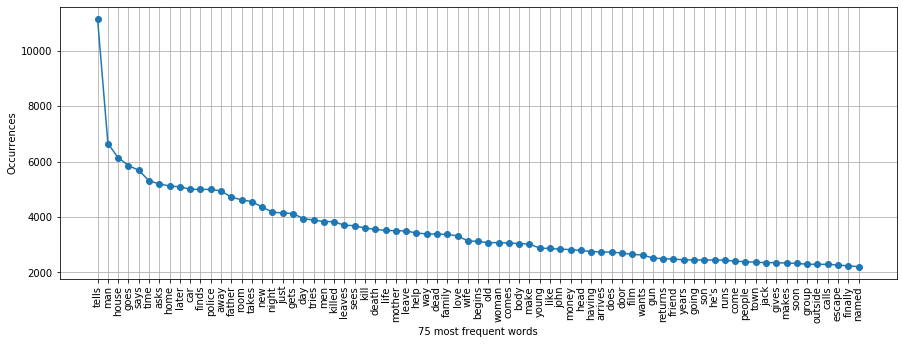

In [10]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot([x[0] for x in occurrences[:75]], [x[1] for x in occurrences[:75]], marker='o')
plt.xticks(rotation=90)
plt.xlabel('75 most frequent words')
plt.ylabel('Occurrences')
plt.show()

## Vocabolario da 1000 parole

In [11]:
n_words = 1000

vocabulary = [occurrences[x][0] for x in range(n_words)]
vocabulary.sort()
vocabulary

['000',
 'abandoned',
 'able',
 'accepts',
 'accident',
 'accidentally',
 'act',
 'actually',
 'adam',
 'admits',
 'affair',
 'agent',
 'agents',
 'ago',
 'agree',
 'agrees',
 'air',
 'airport',
 'alan',
 'alex',
 'alice',
 'alien',
 'alive',
 'allow',
 'allows',
 'american',
 'amy',
 'andy',
 'angel',
 'angeles',
 'angry',
 'ann',
 'anna',
 'anne',
 'annie',
 'announces',
 'answer',
 'answers',
 'apartment',
 'apparently',
 'appear',
 'appears',
 'approaches',
 'area',
 'arm',
 'armed',
 'arms',
 'army',
 'arrest',
 'arrested',
 'arrive',
 'arrives',
 'arriving',
 'arthur',
 'ask',
 'asked',
 'asking',
 'asks',
 'assistant',
 'attack',
 'attacked',
 'attacks',
 'attempt',
 'attempts',
 'attention',
 'audience',
 'aunt',
 'away',
 'baby',
 'bad',
 'bag',
 'band',
 'bank',
 'bar',
 'base',
 'basement',
 'bathroom',
 'batman',
 'battle',
 'beach',
 'beat',
 'beautiful',
 'bed',
 'bedroom',
 'begin',
 'beginning',
 'begins',
 'begs',
 'believe',
 'believes',
 'believing',
 'ben',
 'best',

# Trasformazione dei dati nel formato adatto

In [12]:
from pyspark.ml.linalg import Vectors

def dict_func(x, y):
    z = dict()
    z.update(x)
    z.update(y)
    return z

def featurisation(x):
    occ_vect = []
    plot_terms = x[1]
    for term in vocabulary:
        if term in plot_terms:
            occ_vect.append(plot_terms[term])
        else:
            occ_vect.append(0)
    return (x[0], Vectors.dense(occ_vect))

counted_rdd = id_genres.rdd\
    .map(lambda x: (x.id, x.plot))\
    .map(lambda x: (x[0], x[1].replace(',', ' ').replace('.', ' ').replace('-', ' ')\
    .replace('"', ' ').replace('*', ' ').replace('(', ' ').replace(')', ' ')\
    .replace('[', ' ').replace(']', ' ').replace('{', ' ').replace('}', ' ')\
    .replace(':', ' ').replace(';', ' ').replace('$', ' ').replace('=', ' ').lower()))\
    .map(lambda x: (x[0], x[1].split()))\
    .flatMap(lambda x: [str(x[0]) + '.' + str(item) for item in x[1]])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)

features_rdd = counted_rdd.filter(lambda x: x[0].split('.')[1] in vocabulary)\
    .map(lambda x: (x[0].split('.')[0], {x[0].split('.')[1]: x[1]}))\
    .filter(lambda x: type(x[1]) is dict and type(x) is not None)\
    .reduceByKey(dict_func).map(featurisation)

spark = SparkSession.builder.appName('Words DF').getOrCreate()
vocab_words_df = spark.createDataFrame(features_rdd, ['feat_id', 'features'])
vocab_words_df.show()

+---------+--------------------+
|  feat_id|            features|
+---------+--------------------+
|tt0022958|[0.0,0.0,1.0,1.0,...|
|tt0051297|[0.0,0.0,0.0,0.0,...|
|tt0090163|[0.0,0.0,0.0,0.0,...|
|tt0057334|[0.0,0.0,0.0,0.0,...|
|tt0451010|[0.0,1.0,0.0,0.0,...|
|tt0216787|[0.0,0.0,0.0,0.0,...|
|tt0114863|[0.0,0.0,1.0,0.0,...|
|tt0054189|[0.0,0.0,0.0,0.0,...|
|tt0092890|[0.0,0.0,0.0,0.0,...|
|tt0082797|[0.0,0.0,0.0,0.0,...|
|tt0057779|[0.0,0.0,0.0,0.0,...|
|tt0263101|[0.0,0.0,0.0,0.0,...|
|tt0280653|[0.0,0.0,0.0,0.0,...|
|tt0116508|[0.0,0.0,0.0,0.0,...|
|tt0090466|[0.0,0.0,0.0,0.0,...|
|tt0040974|[1.0,0.0,0.0,0.0,...|
|tt4805880|[0.0,0.0,0.0,0.0,...|
|tt0462499|[0.0,0.0,1.0,0.0,...|
|tt0098253|[0.0,0.0,0.0,0.0,...|
|tt0119665|[0.0,1.0,0.0,0.0,...|
+---------+--------------------+
only showing top 20 rows



# Divisione tra training, test e validazione

In [13]:
type_df = vocab_words_df.join(id_genres, vocab_words_df.feat_id == id_genres.id)\
    .select('label', 'type', 'features')

genres_list = type_df.select('label').distinct().rdd.map(lambda x: x[0]).collect()
new_genres = dict()
i = 0
for g in genres_list:
    new_genres[g] = i
    i = i + 1

training_data = type_df.filter(type_df.type == 'train').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))
test_data = type_df.filter(type_df.type == 'test').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))
validation_data = type_df.filter(type_df.type == 'val').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))

training_data_df = spark.createDataFrame(training_data, ['label', 'features'])
test_data_df = spark.createDataFrame(test_data, ['label', 'features'])
validation_data_df = spark.createDataFrame(validation_data, ['label', 'features'])

# Test naive Bayes

In [14]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType='multinomial')
model = nb.fit(training_data_df)
nb_predictions = model.transform(test_data_df)

n_observations = nb_predictions.rdd.count()
right = nb_predictions.rdd\
    .map(lambda x: x[0] - int(x[4]))\
    .filter(lambda x: x == 0)\
    .count()
accuracy = (right / n_observations) * 100

print('Accuracy:', accuracy)
nb_predictions.show()

Accuracy: 82.98022598870057
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[1.0,0.0,0.0,1.0,...|[-1035.7615776543...|[0.99999999999907...|       0.0|
|    0|[1.0,0.0,0.0,0.0,...|[-607.50994869366...|[0.91216703416319...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[-647.80177658399...|[0.99999999358380...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[-408.70910430234...|[0.92733762469814...|       0.0|
|    0|[0.0,1.0,0.0,0.0,...|[-752.91498559720...|[0.99999999999275...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[-248.15541060698...|[0.59652130437162...|       0.0|
|    0|[0.0,0.0,2.0,0.0,...|[-1442.4857347982...|[0.99999999997586...|       0.0|
|    0|[0.0,0.0,3.0,1.0,...|[-5607.1146966535...|[1.0,1.7774091608...|       0.0|
|    1|[0.0,0.0,2.0,0.0,...|[-1636.0648823462...|[0.99999999999162...|

In [15]:
from pyspark.mllib.evaluation import MulticlassMetrics
nb_metrics = MulticlassMetrics(nb_predictions.rdd.map(lambda x: (float(x.prediction), float(x.label))))
nb_metrics.confusionMatrix().toArray()

array([[840., 152.],
       [ 89., 335.]])

# Test logistic regression

In [16]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(maxIter=5, tol=1E-6, fitIntercept=True)
lr_model = lr.fit(training_data_df)
lr_predictions = lr_model.transform(test_data_df)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = evaluator.evaluate(lr_predictions)

print("Test Error = %g" % (1.0 - accuracy))
lr_predictions.show()

Test Error = 0.141243
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[1.0,0.0,0.0,1.0,...|[3.49624474221712...|[0.97058073174049...|       0.0|
|    0|[1.0,0.0,0.0,0.0,...|[0.72122639846445...|[0.67287702118114...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[2.99519472956517...|[0.95235656803969...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[1.22001107050636...|[0.77206549762440...|       0.0|
|    0|[0.0,1.0,0.0,0.0,...|[2.75328254038026...|[0.94009846789667...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.90257917920870...|[0.71147923623578...|       0.0|
|    0|[0.0,0.0,2.0,0.0,...|[3.60227318513169...|[0.97346179497257...|       0.0|
|    0|[0.0,0.0,3.0,1.0,...|[11.1090503532883...|[0.99998502405527...|       0.0|
|    1|[0.0,0.0,2.0,0.0,...|[3.71146971607813...|[0.97614156308208...|      

In [17]:
lr_metrics = MulticlassMetrics(lr_predictions.rdd.map(lambda x: (float(x.prediction), float(x.label))))
lr_metrics.confusionMatrix().toArray()

array([[917.,  75.],
       [125., 299.]])

# Test OvA SVC lineare

In [18]:
from pyspark.ml.classification import LinearSVC
import time
start = time.time()

lsvc = LinearSVC(maxIter=10, regParam=0.1)
lsvc_model = lsvc.fit(training_data_df)
svc_predictions = lsvc_model.transform(test_data_df)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = evaluator.evaluate(svc_predictions)

end = time.time()
print('Computing time (minutes):', (end - start) / 60)
print("Test Error = %g" % (1.0 - accuracy))
svc_predictions.show()

Computing time (minutes): 1.3104987025260926
Test Error = 0.126412
+-----+--------------------+--------------------+----------+
|label|            features|       rawPrediction|prediction|
+-----+--------------------+--------------------+----------+
|    0|[1.0,0.0,0.0,1.0,...|[2.32080479399446...|       0.0|
|    0|[1.0,0.0,0.0,0.0,...|[0.20552298415568...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[2.21801846030029...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.88615399117088...|       0.0|
|    0|[0.0,1.0,0.0,0.0,...|[1.47792496070705...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.25023063311443...|       0.0|
|    0|[0.0,0.0,2.0,0.0,...|[2.69425243038177...|       0.0|
|    0|[0.0,0.0,3.0,1.0,...|[7.28465112886475...|       0.0|
|    1|[0.0,0.0,2.0,0.0,...|[3.00514986412310...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.20091320221982...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[1.49911408016433...|       0.0|
|    1|[0.0,0.0,0.0,0.0,...|[-0.5969492991221...|       1.0|
|    0|[0.0,0.0,0.

In [19]:
svc_metrics = MulticlassMetrics(svc_predictions.rdd.map(lambda x: (float(x.prediction), float(x.label))))
svc_metrics.confusionMatrix().toArray()

array([[926.,  66.],
       [113., 311.]])

# Fine

In [20]:
sc.stop()